# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
import numpy as np

max_depth = 3
num_pct = 10
max_features = None
min_gain = 0.01

In [6]:
j = 1
print(X_train.columns[j])

# Split the variable in num_ctp points
splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

# Only unique values for filter binary and few unique values features
splits = np.unique(splits)

splits

Mileage


array([6.000000e+00, 1.603480e+04, 2.324080e+04, 2.987540e+04,
       3.565100e+04, 4.160950e+04, 4.849280e+04, 6.199830e+04,
       8.097420e+04, 1.061537e+05])

In [7]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [8]:
k = 5
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [9]:
gini_l = gini(y_l)
gini_r = gini(y_r)

In [10]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [11]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [12]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.18461348803714583

In [13]:
j, split, gain = best_split(X_train,y_train,num_pct)
j, split, gain

(1, 52187.63636363637, 0.23872134898880762)

In [14]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [15]:
tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [16]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [17]:
tree_predict(X_test, tree)

array([0., 1., 1., ..., 1., 1., 0.])

In [18]:
from sklearn import metrics
print('The accuracy score is',metrics.accuracy_score(y_test,tree_predict(X_test, tree)))

The accuracy score is 0.8619815668202765


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [19]:
n_estimators = 10
np.random.seed(123)
n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 

seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}

# 100 decision trees where max_depth=None
for i in range(0,10):
    trees[i] = tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=3, num_pct=10)   

In [21]:
# Predict the estimators

# Create an empty DataFrame as big as much estimators are
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

# Predict and fill the DF results matrix
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
332784,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# For each observation, sum the columns
y_pred_df.sum(axis=1)[:5]

332784     1.0
146436    10.0
130476    10.0
85618     10.0
75474      0.0
dtype: float64

In [23]:
from sklearn import metrics

# Ensemble using majority voting (50+1 %)
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

print('F1 score', metrics.f1_score(y_pred, y_test))
print('Accuracy score', metrics.accuracy_score(y_pred, y_test))

F1 score 0.8915617365156926
Accuracy score 0.8670506912442396


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [25]:
max_features=5
nums = np.arange(0, max_features)
features = np.random.choice(a=nums, size=9, replace=True)
features

array([4, 4, 1, 1, 3, 2, 3, 2, 3])

In [26]:
def best_split2(X, y, num_pct, max_features):
    
    #features = range(X.shape[1])
    nums = np.arange(0, max_features)
    features = np.random.choice(a=nums, size=9, replace=True)
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [27]:
def tree_grow2(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=4):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    #X2=random_features(X_train,max_features)
    j, split, gain = best_split2(X, y, num_pct, max_features)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow2(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    tree['sr'] = tree_grow2(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    
    return tree

In [28]:
from sklearn import metrics
max_features = 9
tree = tree_grow2(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=max_features)
tr = tree_predict(X_test, tree)
#tr = tree_predict(random_features(X_test,max_features=max_features), tree)
metrics.accuracy_score(y_test, tr)

0.8675115207373272

In [29]:
# list of values to try for max_features
max_features_range = np.arange(1, 10, 1)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# 
for i in range(9):
    tree = tree_grow2(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=max_features_range[i])
    #tr = tree_predict(random_features(X_test,max_features_range[i]), tree)
    tr = tree_predict(X_test, tree)
    #accuracy_scores.append([i+1,metrics.accuracy_score(y_test, tr)])
    accuracy_scores.append(metrics.accuracy_score(y_test, tr))

In [30]:
accuracy_scores

[0.8495391705069124,
 0.8610599078341014,
 0.8610599078341014,
 0.8610599078341014,
 0.8610599078341014,
 0.8615207373271889,
 0.864516129032258,
 0.867741935483871,
 0.8610599078341014]

Text(0,0.5,'Accuracy')

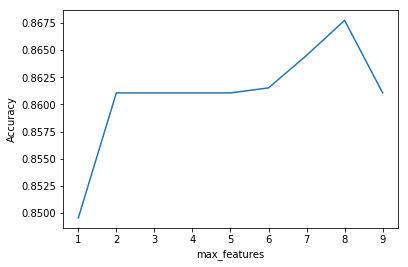

In [33]:
import matplotlib.pyplot as plt

plt.plot(max_features_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [39]:
print('The max_features value that maximize the accuracy is 8 ')

The max_features value that maximize the accuracy is 8 


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [41]:
#Estimate 10 bagged samples

np.random.seed(123)
n_samples = X_train.shape[0]
n_estimators = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_estimators +1 )]
samples

[array([3582, 1346, 5218, ..., 5288, 5094, 8043]),
 array([ 431, 3426, 8463, ..., 8218,  237, 8326]),
 array([8477, 4773, 5743, ..., 1809,  214, 6910]),
 array([5885, 1492, 7249, ..., 1834,  137, 7586]),
 array([ 352, 4574, 5708, ..., 7142, 2081, 7438]),
 array([2311, 6342, 4124, ..., 8286, 8453, 1222]),
 array([5003, 7878, 7832, ..., 3522,  407, 3676]),
 array([6901, 1829, 1437, ..., 8100, 3585,  522]),
 array([2874, 2197, 2888, ...,  477, 5922, 4068]),
 array([5547, 7784, 7473, ..., 4908, 6648, 3622])]

In [43]:
import math

seeds = np.random.randint(1, 10000, size=n_estimators)
max_features = int(round(math.log(9),0))
print('max_features=' ,max_features)

trees = {}
for i in range(0,n_estimators):
    trees[i] = tree_grow2(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=max_features)

max_features= 2


In [44]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    #y_pred_df.iloc[:, i] = trees[i].predict(X_test)
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

y_pred_df.head()

,0,1,2,3,4,5,6,7,8,9
332784,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#Ensemble using majority voting
y_pred_df.sum(axis=1)[:10]

332784     1.0
146436    10.0
130476    10.0
85618     10.0
75474      0.0
330419     0.0
205915    10.0
2836       8.0
250833    10.0
126784     0.0
dtype: float64

In [57]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

from sklearn import metrics
#print("f1 score: ",metrics.f1_score(y_pred, y_test))
print("The accuracy for the testing set is",metrics.accuracy_score(y_pred, y_test))

The accuracy for the testing set is 0.8668202764976959


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [51]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3)
clf

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
from sklearn.model_selection import cross_val_score

pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.867909
std       0.008385
min       0.857795
25%       0.861217
50%       0.866160
75%       0.875119
max       0.880518
dtype: float64

In [56]:
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("The accuracy using sklearn is",metrics.accuracy_score(y_pred, y_test))

The accuracy using sklearn is 0.8617511520737328


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [58]:
# list of values to try for max_depth
estimator_range = range(1, 10, 1)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=150, random_state=1, n_jobs=-1,max_depth=estimator)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

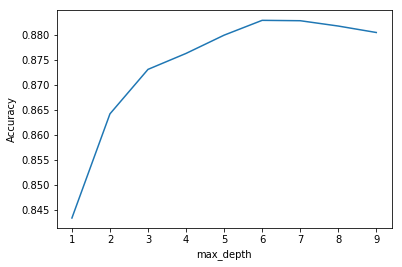

In [59]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [65]:
## Tuning n estimators

# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1,max_depth=6)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

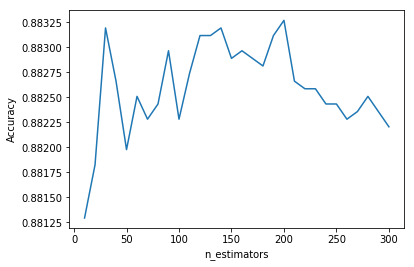

In [61]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [67]:
## Tuning for max_features

# list of values to try for max_features
feature_range = range(1, 10)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(max_depth=6, n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

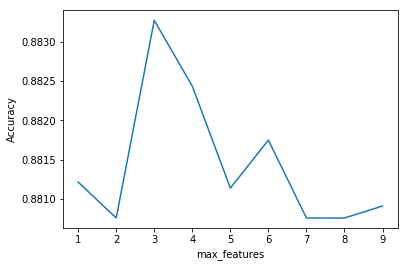

In [68]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [69]:
# max_features=2 is best and n_estimators=200 is sufficiently large
clf = RandomForestClassifier(max_depth=6, n_estimators=200, max_features=3, random_state=1, n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("accuracy: ",metrics.accuracy_score(y_pred, y_test))

accuracy:  0.8788018433179724
